# **IMPORTADO DE MÓDULOS/FUNCIONES**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d


from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import initializers
from keras.regularizers import l2
from keras.optimizers import Adam

import tensorflow as tf
tf.version.VERSION 

2024-06-11 21:25:49.880940: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 21:25:49.904355: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 21:25:50.274966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.16.1'

In [3]:
V55 = np.load('/home/josea/Co60_5cm_5cm.npy')
V28 = np.load('/home/josea/Co60_2cm_8cm.npy')
V82 = np.load('/home/josea/Co60_8cm_2cm.npy')

In [4]:
from functions import gauss, gauss_fit, weights_definition, create_and_delay_pulse_pair, pulso, pulso_escalon, pulso_sigmoid, get_mean_pulse_from_set, momentos
from Models import model_definition_manual_weight_initialization,  Fit_to_exp_model, custom_loss, CustomOutputLayer, model_definition_convolutional

# **INTERPOLATION**

In [5]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28, kind = 'cubic', axis = 1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55, kind = 'cubic', axis = 1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82, kind = 'cubic', axis = 1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


In [6]:
#----------------------------- Start and stop points for pulse cropping -----------------
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING

#----------------------------- Create array of all positions ----------------------------
pulsos_reales = np.concatenate((new_V28,new_V55,new_V82), axis = 0)
print(pulsos_reales.shape)

(736, 4800, 2)


In [7]:
#------------------------------------- Basic definitions ----------------------------------------
Ncasos_sim = 0
Ncasos_real = int(pulsos_reales.shape[0])
Nc = 2

t = np.linspace(0,Nt,Nt_new)
#t0 = 65 + np.random.randint(5, size = Ncasos) 
t0 = 550 + np.random.randint(100, size = int(Ncasos_sim + Ncasos_real))
#t0 = 78 + np.random.randint(5, size = int(Ncasos_sim + Ncasos_real)) 

# **GENERATE MEAN PULSE PER DETECTOR**

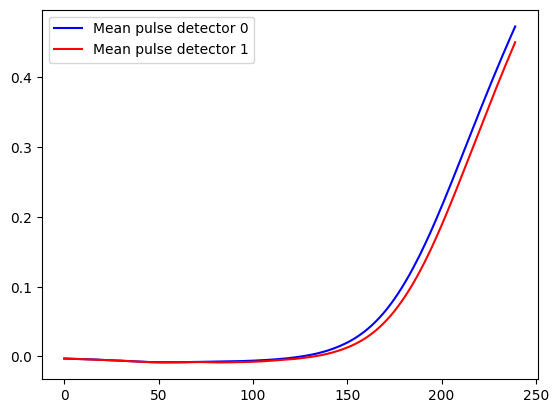

In [8]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_V55, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_V55, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

# **PREPROCESSING**

In [9]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 3
tau_drop_dec0 = 150
Photon_yield = 100
center_window_dec0 = 0.3
rise_window_dec0 = 0.3

#--------------------------------- Detector 1 definitions -------------------------
tau_rise_dec1 = 3
tau_drop_dec1 = 150
Photon_yield = 100
center_window_dec1 = 0.3
rise_window_dec1 = 0.3

Text(0, 0.5, 'Voltage [A.U]')

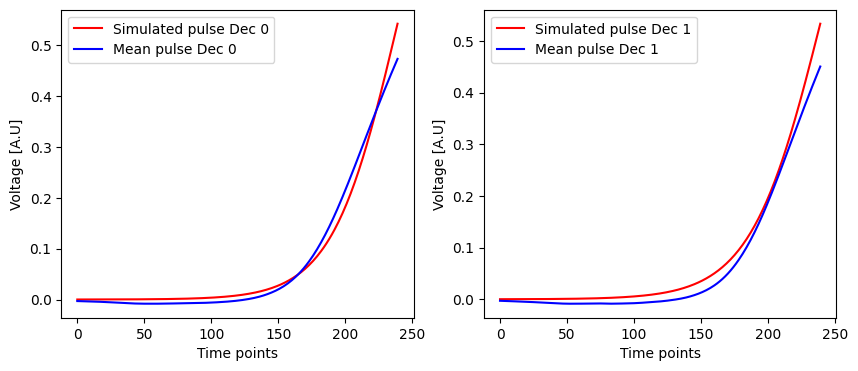

In [10]:
#pulso_original_dec0 = pulso(t, 70, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)
#pulso_original_dec1 = pulso(t, 70, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1)
pulso_original_dec0 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
pulso_original_dec1 =  pulso_sigmoid(tiempo_new, 80, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = True)

plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(pulso_original_dec0[start:stop],'r-', label = 'Simulated pulse Dec 0')
plt.plot(mean_pulse_dec0[start:stop],'b-', label = 'Mean pulse Dec 0')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')

plt.subplot(122)
plt.plot(pulso_original_dec1[start:stop],'r-', label = 'Simulated pulse Dec 1')
plt.plot(mean_pulse_dec1[start:stop],'b-', label = 'Mean pulse Dec 1')
plt.legend()
plt.xlabel('Time points')
plt.ylabel('Voltage [A.U]')

In [11]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Ncasos_sim,Nt_new))
INPUT_dec1 = np.zeros((Ncasos_sim,Nt_new))


for i in range(Ncasos_sim):
  centro = t0[i]
  #PULSO_dec0 = pulso(t, centro,  tau_rise = tau_rise_dec0)
  #PULSO_dec1 = pulso(t, centro, tau_rise = tau_rise_dec1)
  PULSO_dec0 = pulso_escalon(t, centro, A = 0.7)
  PULSO_dec1 = pulso_escalon(t, centro, A = 0.7)
  #PULSO_dec0 = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
  #PULSO_dec1 = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = False)
  INPUT_dec0[i,:] = PULSO_dec0
  INPUT_dec1[i,:] = PULSO_dec1


In [12]:
#-------------------------------- Delay simulated pulses --------------------------------------------
INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(INPUT_dec0, new_time_step, delay_steps = 32, NOISE = True)
INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(INPUT_dec1, new_time_step, delay_steps = 32, NOISE = True)

#--------------------------------- Delay mean pulse ----------------------------------------------------
INPUT2_dec0, REF2_dec0 = create_and_delay_pulse_pair(pulsos_reales[:Ncasos_real,:,0], new_time_step, delay_steps = 32, NOISE = True)
INPUT2_dec1, REF2_dec1 = create_and_delay_pulse_pair(pulsos_reales[:Ncasos_real,:,1], new_time_step, delay_steps = 32, NOISE = True)

#--------------------------------- Create train set ----------------------------------------------------
trainX_dec0 = np.concatenate((INPUT_dec0[:,start:stop,:], INPUT2_dec0[:,start:stop,:]), axis = 0)
trainX_dec1 = np.concatenate((INPUT_dec1[:,start:stop,:], INPUT2_dec1[:,start:stop,:]), axis = 0)

REF_train_dec0 = np.concatenate((REF_dec0[:], REF2_dec0[:]))
REF_train_dec1 = np.concatenate((REF_dec1[:], REF2_dec1[:]))

<Axes: title={'center': 'Detector 1'}>

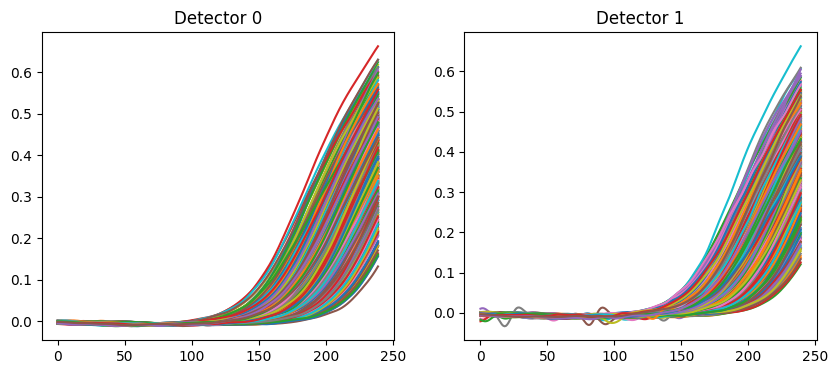

In [13]:
plt.figure(figsize = (10,4))

plt.subplot(121)
for i in range(trainX_dec0.shape[0]):
  plt.plot(trainX_dec0[i,:,0])
plt.title('Detector 0')
plt.subplot(122)
for i in range(trainX_dec1.shape[0]):
  plt.plot(trainX_dec1[i,:,0])
plt.title('Detector 1')
plt.subplot(122)


In [14]:
#--------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)
M_Train_dec1 = momentos(trainX_dec1)

#------------------------------------------ Normalize -------------------------------------------------
min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec0 = (M_Train_dec0 - min_dec0)/(max_dec0 - min_dec0)
M_Train_dec1 = (M_Train_dec1 - min_dec1)/(max_dec1 - min_dec1)

#------------------------------------ Print Important information -----------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print('Min detector 0: ', min_dec0)
print('Max detector 0: ', max_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print('Min detector 1: ', min_dec1)
print('Max detector 1: ', max_dec1)

(736, 12, 2) NM = 12
Min detector 0:  -0.1724058128561671
Max detector 0:  35.90071905548042
(736, 12, 2) NM = 12
Min detector 1:  -0.1787473971984848
Max detector 1:  32.08453747136719


# **MULTIPLE TRAINING**

In [23]:
REFERENCE_PULSE_dec0 = np.tile(mean_pulse_dec0[start:stop], (new_V82.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(mean_pulse_dec1[start:stop], (new_V82.shape[0],2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
 
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0 - min_dec0)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1 - min_dec1)

M_V55 = momentos(new_V55[:,start:stop,:])
M_V55_norm = np.zeros_like(M_V55)
M_V55_norm[:,:,0] = (M_V55[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_V55_norm[:,:,1] = (M_V55[:,:,1] - min_dec1)/(max_dec1-min_dec1)

M_V28 = momentos(new_V28[:,start:stop,:])
M_V28_norm = np.zeros_like(M_V28)
M_V28_norm[:,:,0] = (M_V28[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_V28_norm[:,:,1] = (M_V28[:,:,1] - min_dec1)/(max_dec1-min_dec1)

M_V82 = momentos(new_V82[:,start:stop,:])
M_V82_norm = np.zeros_like(M_V82)
M_V82_norm[:,:,0] = (M_V82[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_V82_norm[:,:,1] = (M_V82[:,:,1] - min_dec1)/(max_dec1-min_dec1)

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

class ExpModel(nn.Module):
    def __init__(self, NM, NN = 32, STD_INIT = 1):
        super(ExpModel, self).__init__()
        self.dense1 = nn.Linear(NM, NN)
        self.dense2 = nn.Linear(NN, NN)
        self.dense3 = nn.Linear(NN, NN)
        self.dense4 = nn.Linear(NN, NN)
        self.output = nn.Linear(NN, 1)
        
        nn.init.normal_(self.dense1.weight, mean=0.0, std=STD_INIT)
        nn.init.normal_(self.dense2.weight, mean=0.0, std=STD_INIT)
        nn.init.normal_(self.dense3.weight, mean=0.0, std=STD_INIT)
        nn.init.normal_(self.dense4.weight, mean=0.0, std=STD_INIT)
        nn.init.normal_(self.output.weight, mean=0.0, std=STD_INIT)

    def forward(self, inputA, inputB):
        xA = torch.relu(self.dense1(inputA))
        xA = torch.relu(self.dense2(xA))
        xA = torch.relu(self.dense3(xA))
        xA = torch.relu(self.dense4(xA))
        outA = self.output(xA)
        
        xB = torch.relu(self.dense1(inputB))
        xB = torch.relu(self.dense2(xB))
        xB = torch.relu(self.dense3(xB))
        xB = torch.relu(self.dense4(xB))
        outB = self.output(xB)
        
        return outA, outB

    
def custom_loss(outA, outB, input_REF):
    loss1 = torch.mean((outA - outB - input_REF)**2)
    return loss1



def train_model(model, optimizer, train_loader, epochs = 50):
    model.train()
    for epoch in range(epochs):
        for inputA, inputB, input_REF in train_loader:
            optimizer.zero_grad()
            outA, outB = model(inputA, inputB)
            loss = custom_loss(outA, outB, input_REF)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

In [76]:
# Assuming trainX_dec0, trainX_dec1, REF_train_dec0, and REF_train_dec1 are numpy arrays
M_Train_dec0 = torch.tensor(M_Train_dec0, dtype = torch.float32)
M_Train_dec1 = torch.tensor(M_Train_dec1, dtype = torch.float32)
REF_train_dec0 = torch.tensor(REF_train_dec0, dtype = torch.float32)
REF_train_dec1 = torch.tensor(REF_train_dec1, dtype = torch.float32)

# Create a DataLoader
train_dataset_dec0 = torch.utils.data.TensorDataset(M_Train_dec0[:,:,0], M_Train_dec0[:,:,1], REF_train_dec0)
train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle=True)

train_dataset_dec1 = torch.utils.data.TensorDataset(M_Train_dec1[:,:,0], M_Train_dec1[:,:,1], REF_train_dec1)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle=True)


# Instantiate the model, optimizer
model_dec0 = ExpModel(NM = NM, NN = 32, STD_INIT = 1)
model_dec1 = ExpModel(NM = NM, NN = 32, STD_INIT = 1)
optimizer_dec0 = optim.Adam(model_dec0.parameters(), lr = 1e-5)
optimizer_dec1 = optim.Adam(model_dec1.parameters(), lr = 1e-5)

# Train the model
train_model(model_dec0, optimizer_dec0, train_loader_dec0, epochs = 1500)
train_model(model_dec1, optimizer_dec1, train_loader_dec1, epochs = 1500)

Epoch 231/1500, Loss: 2.558791160583496
Epoch 232/1500, Loss: 0.9782712459564209
Epoch 233/1500, Loss: 3.148176431655884
Epoch 234/1500, Loss: 0.4441356062889099
Epoch 235/1500, Loss: 0.4202139973640442
Epoch 236/1500, Loss: 0.8166327476501465
Epoch 237/1500, Loss: 1.0215984582901
Epoch 238/1500, Loss: 3.0941619873046875
Epoch 239/1500, Loss: 0.46037161350250244
Epoch 240/1500, Loss: 0.5595710277557373
Epoch 241/1500, Loss: 2.4910969734191895
Epoch 242/1500, Loss: 0.8252841234207153
Epoch 243/1500, Loss: 0.43111011385917664
Epoch 244/1500, Loss: 0.6153817772865295
Epoch 245/1500, Loss: 0.6175533533096313
Epoch 246/1500, Loss: 0.830687940120697
Epoch 247/1500, Loss: 1.3261754512786865
Epoch 248/1500, Loss: 1.674248218536377
Epoch 249/1500, Loss: 0.672580897808075
Epoch 250/1500, Loss: 2.8670578002929688
Epoch 251/1500, Loss: 2.487873077392578
Epoch 252/1500, Loss: 1.4299408197402954
Epoch 253/1500, Loss: 0.8871369957923889
Epoch 254/1500, Loss: 1.7595417499542236
Epoch 255/1500, Loss: 0

In [77]:
model_dec0.eval()
model_dec1.eval()

# Function to make predictions
def make_predictions(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():  # No need to compute gradients for prediction
        for inputA, inputB in data_loader:
            outA, outB = model(inputA, inputB)
            predictions.append((outA, outB))
    return predictions

def process_predictions(predictions):
    outA_list, outB_list = [], []
    for outA, outB in predictions:
        outA_list.append(outA.numpy())
        outB_list.append(outB.numpy())
    outA_array = np.concatenate(outA_list, axis = 0)
    outB_array = np.concatenate(outB_list, axis = 0)
    return outA_array, outB_array


# Create DataLoader for the prediction data
new_V82_tensor = torch.tensor(M_V82_norm, dtype = torch.float32)
new_V55_tensor = torch.tensor(M_V55_norm, dtype = torch.float32)
new_V28_tensor = torch.tensor(M_V28_norm, dtype = torch.float32)

REFERENCE_PULSE_dec0_tensor = torch.tensor(M_REF_dec0, dtype = torch.float32)
REFERENCE_PULSE_dec1_tensor = torch.tensor(M_REF_dec1, dtype = torch.float32)

prediction_dataset_dec0_V82 = torch.utils.data.TensorDataset(new_V82_tensor[:,:,0], REFERENCE_PULSE_dec0_tensor[:new_V82.shape[0],:,0])
prediction_dataset_dec0_V55 = torch.utils.data.TensorDataset(new_V55_tensor[:,:,0], REFERENCE_PULSE_dec0_tensor[:new_V55.shape[0],:,0])
prediction_dataset_dec0_V28 = torch.utils.data.TensorDataset(new_V28_tensor[:,:,0], REFERENCE_PULSE_dec0_tensor[:new_V28.shape[0],:,0])

prediction_loader_dec0_V82 = torch.utils.data.DataLoader(prediction_dataset_dec0_V82, batch_size = 32, shuffle = False)
prediction_loader_dec0_V55 = torch.utils.data.DataLoader(prediction_dataset_dec0_V55, batch_size = 32, shuffle = False)
prediction_loader_dec0_V28 = torch.utils.data.DataLoader(prediction_dataset_dec0_V28, batch_size = 32, shuffle = False)

prediction_dataset_dec1_V82 = torch.utils.data.TensorDataset(new_V82_tensor[:,:,1], REFERENCE_PULSE_dec0_tensor[:new_V82.shape[0],:,0])
prediction_dataset_dec1_V55 = torch.utils.data.TensorDataset(new_V55_tensor[:,:,1], REFERENCE_PULSE_dec0_tensor[:new_V55.shape[0],:,0])
prediction_dataset_dec1_V28 = torch.utils.data.TensorDataset(new_V28_tensor[:,:,1], REFERENCE_PULSE_dec0_tensor[:new_V28.shape[0],:,0])

prediction_loader_dec1_V82 = torch.utils.data.DataLoader(prediction_dataset_dec1_V82, batch_size = 32, shuffle = False)
prediction_loader_dec1_V55 = torch.utils.data.DataLoader(prediction_dataset_dec1_V55, batch_size = 32, shuffle = False)
prediction_loader_dec1_V28 = torch.utils.data.DataLoader(prediction_dataset_dec1_V28, batch_size = 32, shuffle = False)


# Make predictions
predictions_dec0_V82 = make_predictions(model_dec0, prediction_loader_dec0_V82)
predictions_dec0_V55 = make_predictions(model_dec0, prediction_loader_dec0_V55)
predictions_dec0_V28 = make_predictions(model_dec0, prediction_loader_dec0_V28)

predictions_dec1_V82 = make_predictions(model_dec1, prediction_loader_dec1_V82)
predictions_dec1_V55 = make_predictions(model_dec1, prediction_loader_dec1_V55)
predictions_dec1_V28 = make_predictions(model_dec1, prediction_loader_dec1_V28)


In [78]:
outA_dec0_V82, outB_dec0_V82 = process_predictions(predictions_dec0_V82)
outA_dec0_V55, outB_dec0_V55 = process_predictions(predictions_dec0_V55)
outA_dec0_V28, outB_dec0_V28 = process_predictions(predictions_dec0_V28)

outA_dec1_V82, outB_dec1_V82 = process_predictions(predictions_dec1_V82)
outA_dec1_V55, outB_dec1_V55 = process_predictions(predictions_dec1_V55)
outA_dec1_V28, outB_dec1_V28 = process_predictions(predictions_dec1_V28)


TOFN_V82 = np.squeeze(outA_dec0_V82) - np.squeeze(outA_dec1_V82)
TOFN_V55 = np.squeeze(outA_dec0_V55) - np.squeeze(outA_dec1_V55)
TOFN_V28 = np.squeeze(outA_dec0_V28) - np.squeeze(outA_dec1_V28)

In [79]:
centroid_V28 = np.mean(TOFN_V28) - np.mean(TOFN_V55)
centroid_V82 = np.mean(TOFN_V82) - np.mean(TOFN_V55)
mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
epsilon = np.sqrt(mean_error_centroid**2 + mean_std**2)
print(epsilon)

1.2599174374742625



V82: CENTROID(ns) = 0.307  FWHM(ns) = 26.123  std(ns) = 11.093
V55: CENTROID(ns) = 0.284  FWHM(ns) = 0.314  std(ns) = 0.133
V28: CENTROID(ns) = 0.371  FWHM(ns) = 0.428  std(ns) = 0.182


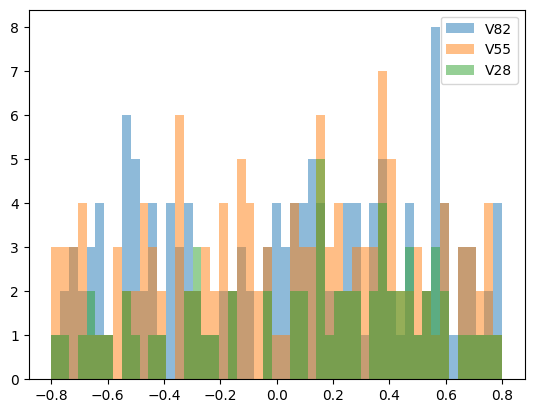

In [80]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins = 51
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82 - np.mean(TOFN_V55), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55 - np.mean(TOFN_V55), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28 - np.mean(TOFN_V55), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))